In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('images/fit11.csv', index_col=0)
df_lum = pd.read_csv('/storeA/ryzhenenkov/lum2011.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
df_triggers = pd.read_csv('images/triggers11.csv', index_col=0)
df = df.join(df_lum).join(df_triggers[['eff_trig', 'eff_trig_err']])
df['n0_mc'] = 20000

In [5]:
df['eff_reg'], df['eff_reg_err'] = df['n_mc']/df['n0_mc'], df['n_mc_err']/df['n0_mc']

In [6]:
df['cs_vis'] = (df['n_exp']*df['f_exp'])/(df['eff_reg']*df['eff_trig']*df['lum'])

In [7]:
df_koz = pd.read_csv('images/kozyrev.txt')
df_koz['emeas'] = df_koz['E']/2
df_koz['cs_vis'] = df_koz['cs']*df_koz['rad']

In [8]:
df_vis = pd.concat([df_koz[['emeas', 'cs_vis']], df[['emeas', 'cs_vis']]], ignore_index=True).sort_values(by='emeas')
df_vis['rad'] = 1
df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [18]:
df_vis.head()

,emeas,cs_vis,rad,cs_born
0,502.0330,4.9464,0.728405,6.790727
1,505.2330,30.7768,0.728863,42.225789
2,506.4775,69.6528,0.722622,96.389037
3,507.5340,155.8663,0.713737,218.380568
4,508.0525,260.0943,0.711733,365.437876


In [10]:
df_approx = pd.read_csv('../data/cross_sections_kskl.txt', sep=' ', index_col=0, names=['E', 'cs_born'])
df_approx['emeas'] = df_approx['E']/2
df_approx['rad'] = 1

In [11]:
from scipy.interpolate import make_interp_spline

In [12]:
df_approx

,E,cs_born,emeas,rad
2,995.0,0.000000,497.5,1
3,996.0,0.067593,498.0,1
4,997.0,0.292279,498.5,1
5,998.0,0.642567,499.0,1
6,999.0,1.128050,499.5,1
...,...,...,...,...
545,2092.0,0.368000,1046.0,1
546,2094.0,0.381000,1047.0,1
547,2096.0,0.394000,1048.0,1
548,2098.0,0.409000,1049.0,1


In [13]:
from pylib.radcors import RadCor

1	

/spoolA/petrov/refac20/notebooks/pylib/radcors.py:66: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  0., Xmax, points=[0, 1], limit=50000, epsrel=0.0001)


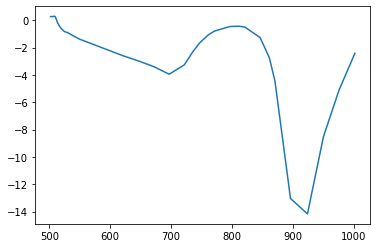

In [14]:
n_iter = 1
last = 70
for _ in range(n_iter):
    print(_+1, end='\t')
    spl = make_interp_spline(df_approx.emeas, df_approx.cs_born, k=1)
    e_interp = np.linspace(495, 1000, 3000) 
    cs_interp = spl(e_interp)
    cs_interp = np.where(e_interp<497.6, 0, cs_interp)
    cs_interp = np.where(cs_interp<0, 0, cs_interp)

    r = RadCor(e_interp, cs_interp)

    temp_rads = df_vis.rad.copy().astype('float')
    for i, j in df_vis.iterrows():
        if (i<=last):#&(i>max(0, last-5)):
            temp_rads[i] = r.F_Radcor(j['emeas'])[0]
#     if (abs(temp_rads[last]-df_vis['rad'][last])<0.05):
#         _ = n_iter-1
#         break
    if (_==(n_iter-1)):
        plt.plot(df_vis['emeas'], df_vis['rad']-temp_rads)
    
    df_vis['rad'] = temp_rads
    df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [15]:
df_vis#.head(50)

,emeas,cs_vis,rad,cs_born
0,502.033000,4.946400,0.728405,6.790727
1,505.233000,30.776800,0.728863,42.225789
2,506.477500,69.652800,0.722622,96.389037
3,507.534000,155.866300,0.713737,218.380568
4,508.052500,260.094300,0.711733,365.437876
5,508.577500,439.705000,0.706027,622.787368
6,508.578000,437.332000,0.706038,619.417411
7,509.023000,697.634000,0.716127,974.176387
8,509.559000,1017.828000,0.735164,1384.490703
9,509.607000,1031.796000,0.736333,1401.263364


<AxesSubplot:>

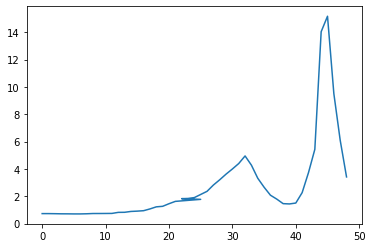

In [16]:
df_vis.rad.plot()

In [19]:
df_n = df.merge(df_vis[['emeas', 'rad']], on='emeas')

In [20]:
df_n['cs_born'] = df_n['cs_vis']/df_n['rad']

In [21]:
df_n.head()

,n_mc,m_mc,sL_mc,sR_mc,aL_mc,aR_mc,k_mc,f_mc,n_mc_err,m_mc_err,...,lum,lum_err,eff_trig,eff_trig_err,n0_mc,eff_reg,eff_reg_err,cs_vis,rad,cs_born
0,2771.089017,1.057710,4.368277,2.849133,0.077535,0.228795,0.0,1.0,37.629448,0.211187,...,491.077,1.04705,0.508592,0.018424,20000,0.138554,0.001881,27.898821,1.771536,15.748379
1,2173.998646,0.863805,3.876588,2.611084,0.078442,0.184523,0.0,1.0,33.142805,0.176397,...,491.865,1.13789,0.713994,0.026779,20000,0.108700,0.001657,11.098689,2.357641,4.707541
2,1905.965871,0.450839,3.533017,2.742736,0.079271,0.172013,0.0,1.0,30.870149,0.197054,...,493.903,1.19121,0.731676,0.040595,20000,0.095298,0.001544,5.598356,2.816812,1.987480
3,1647.975211,0.112701,3.278694,3.132946,0.091126,0.153387,0.0,1.0,28.704967,0.194357,...,557.208,1.30764,0.640310,0.050732,20000,0.082399,0.001435,3.614853,3.203397,1.128444
4,1477.994842,0.291019,3.374207,3.001512,0.080970,0.159534,0.0,1.0,27.176249,0.218890,...,407.739,1.17231,0.771186,0.078031,20000,0.073900,0.001359,2.309584,3.616581,0.638610


In [22]:
# df_n.to_csv('images/res11.csv')

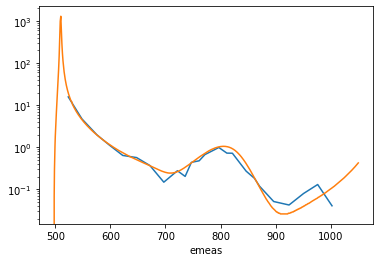

In [23]:
df_n.set_index('emeas').cs_born.plot()
plt.plot(df_approx.emeas, df_approx.cs_born)
plt.yscale('log')

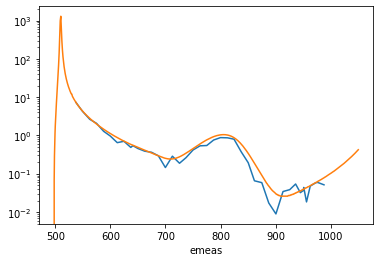

In [64]:
df_n.set_index('emeas').cs_born.plot()
plt.plot(df_approx.emeas, df_approx.cs_born)
plt.yscale('log')

Сечение

In [29]:
dfs = [pd.read_csv('images/res11.csv', index_col=0),
      pd.read_csv('images/res19.csv', index_col=0)]

In [30]:
for df in dfs:
    df['nSig_exp'] = df['n_exp']*df['f_exp']
    df['nSig_err'] = df['nSig_exp']*np.sqrt( (df['n_exp_err']/df['n_exp'])**2 + (df['f_exp_err']/df['f_exp'])**2 )
    df['cs_born_err'] = df['cs_born']*np.sqrt( (df['nSig_err']/df['nSig_exp'])**2 + (df['eff_reg_err']/df['eff_reg'])**2 +\
                                             (df['eff_trig_err']/df['eff_trig'])**2)

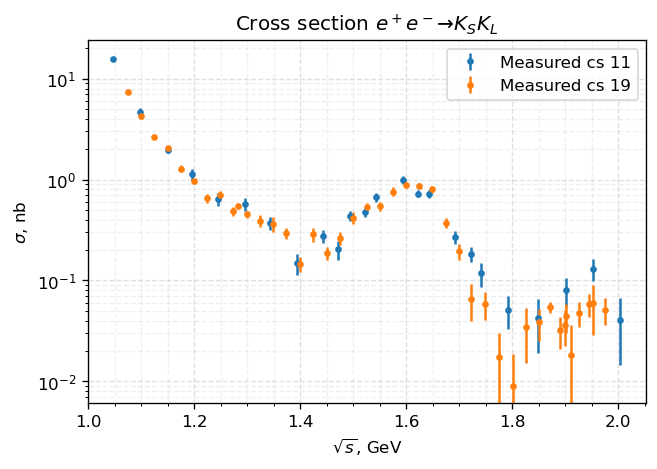

In [35]:
plt.figure(dpi=120)
for df, e in zip(dfs, ['11', '19']):
    plt.errorbar(df.emeas*2e-3, df.cs_born, yerr=df.cs_born_err, fmt='.', label=f'Measured cs {e}')
# plt.plot(df_approx.emeas*2e-3, df_approx.cs_born, label='Cross section in MC')
# plt.errorbar(df_koz.E, df_koz.cs, yerr=df_koz.cs_err, fmt='.')
# plt.xlim(520*2, 1200)
plt.grid(ls='--', alpha=0.4)
plt.grid(which='minor', ls='--', alpha=0.2)
plt.minorticks_on()
plt.legend()
plt.yscale('log')
plt.title('Cross section $e^+ e^- \\to K_S K_L$')
plt.ylabel('$\sigma$, nb')
plt.xlabel('$\sqrt{s}$, GeV');
# plt.savefig('images/cs_kskl1.png', dpi=120)

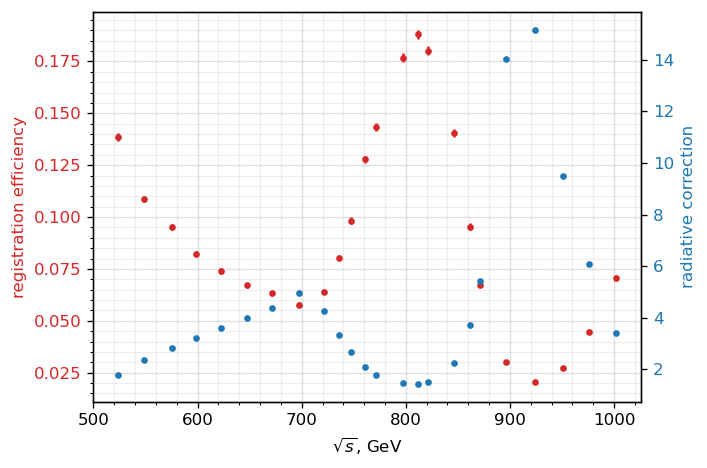

In [27]:
fig, ax1 = plt.subplots(dpi=120)

color = 'tab:red'
ax1.set_xlabel('$\sqrt{s}$, GeV')
ax1.set_ylabel('registration efficiency', color=color)
ax1.errorbar(df.emeas, df.eff_reg, yerr=df.eff_reg_err, fmt='.', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('radiative correction', color=color)  # we already handled the x-label with ax1
ax2.scatter(df.emeas, df.rad, marker='.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid(alpha=0.4)
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('images/rad_reg_eff.png', dpi=120)